# Coursework I - Data Programming in Python (DSM020)
<i>Jude Darmanin (October-March 2022)

<b>Project Proposal:</b> <i>Where words fail, music speaks</i>

A language analysis of popular songs from 1950 onwards and an investigation into the differences and similarities between song genres.

## I. Introduction

Music is an art form that has been prevalent in human society for millenia. Music is diverse and can come in many different forms. Even in today's globalised world, the variety of instruments and cultures gives rise to millions of unique combinations of melody, rythm, texture, harmony, words, and style that form the basis of the music we all hear and love.

### I.I Aims and Objective

The aim of this project is to investigate one aspect of music - music lyrics - and to analyse differences and commonalties between some of the most popular songs in recent years. In particular, I wish to examine differences in lyric style and sentiment between songs in different genres, while identifying the most common themes that have characterised our music in recent decades.

This proposal is split into four sections:
<ol>
    <li> Data collection: This section includes the identification of an appropriate dataset of song lyrics and collecting this data in a form which can be used for further processing and, ultimately, analysis. </li>
    <li> Data Processing: Loading the dataset collected from the previous section using an appropriate data science library, ensuring its adequacy for the project, and rendering the data in a form that can be used for further natural language and possibly other forms of analysis. </li>
    <li> Overall Analysis: Using the prepared and cleaned dataset, this section provides an overview of the whole dataset, focussing on analysis of commonly used words and themes.</li>
    <li> Genre Analysis: In this section, the aim is to analyse songs classified into different genres and identify at a surface-level any commonalities and/or differences between genres, such as theme, use of certain words, sentiment, and song length. </li>
</ol>

The objective behind this analysis is to provide an introductory background for further usage of the dataset. In particular, the dataset will be curated and analysed with the intention of extending the project in the future to build and train a genre classifier for unlabelled songs.

### I.II Importing Required Libraries

In [1]:
#webscraping and data collection
import requests
from bs4 import BeautifulSoup
import csv

#data and visual analysis
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

#text processing
import re
import string
import ast
from itertools import groupby
#from spellchecker import SpellChecker
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk.collocations as collocations
from nltk import FreqDist, bigrams
from nltk import wordnet

#text analysis
from collections import Counter
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
#visualisation settings
%matplotlib inline
sns.set_style("darkgrid")

## II. Data

The dataset used in this study was collected from the SONGLYRICS website (URL: http://www.songlyrics.com/). The website self-identifies as a "<i>social home of critical lyrical thought</i>", where users can review and comment on a song and its lyrics, while also submitting lyrics or lyric corrections. The website's terms and conditions specify that "<i>the Company authorizes you to view and download a single copy of the material on SongLyrics.com solely for your personal, noncommercial use</i>". The site's <i>robots.txt</i> file does not disallow data scraping from the section of the website containing the song lyrics.

Browsing the site, it appears not to have been updated in recent years - the last article in its "Top Stories" page was posted in 2018. Hence, the dataset will probably not contain the more recent songs, though it does contain a wealth of songs from previous decades, going as far back as the 1950s.

### II.I Data Collection

Unfortunately, the website does not provide an index of all songs which can be easily collected. However, the site does contain a section "Top Lyrics" (URL: http://www.songlyrics.com/news/top-songs/all-time/), which allows users to obtain a list of the Top 100 Songs per year from 1950 to 2011. This would give a dataset of over 6,000 observations, which was considered adequate for this exploratory analysis. The website doesn't state how the "Top 100" songs were chosen, though I suspect it is related to the number of upvotes given by users.

For each year, the website provides a table containing the top 100 song lyrics; for each song, the table provides the artist name, linked to the artist page, and the song name, linked to the song page. The song page contains the song lyrics, as well as other information such as the artist name, the album, and the genre. 

Hence, in order to scrape the lyrics and other important song information, the following steps must be carried out:
<ol>
    <li>Obtain link to each year's "Top 100 Songs" page.</li>
    <li>For each indidivual year, grab the link to the song page for each of the top 100 songs.</li>
    <li>For each song, grab the lyrics, the artist name, the album, and the genre.</li>
</ol>

The Requests and BeautifulSoup libaries were used to scrape the data.

#### II.I.I Scraping Year URLs

The "Top 100 Songs of All Time" page contains a dropdown menu linking the "Top 100 Songs" page for each year from 1950 - 2011. I use this page to grab the link for each year's "Top 100 Songs".


In [ ]:
#scraping site content
html=requests.get(f'http://www.songlyrics.com/news/top-songs/all-time/').content
soup=BeautifulSoup(html,"html.parser")

The dropdown menu (tag:'form', name: 'f2') links to the top 100 songs of each year from 1950-2011. The below code grabs each menu option and saves the 'value' attribute, which contains the link. All links are grabbed except the first one, which contains the 'All Time Top 100'. Links are stored in 'year_links' list and saved to file.

In [ ]:
#finding the dropdown menu
year_options = soup.find('form',{'name':'f2'}) 

#scraping and storing year links
year_links = []
for elem in year_options.find_all('option')[1:]:
    year_links.append(elem['value'])

#saving year links to file
with open('urls_year.txt', 'w') as file:
    for item in year_links:
        file.write("%s\n" % item)

#### II.I.II Scraping Song URLs

For each year, the top 100 songs are contained in a 'table' with class 'tracklist' - all links in this table are grabbed and saved in 'links_temp' list. In each row, the table contains a link to artist page (even index number) and a link to the song page (odd index number). I am only interested in the song page, so I grab links with odd index numbers and store them in the 'songs_links' list.

In [ ]:
#reading year links from file
with open('urls_year.txt') as file:
    lines = file.readlines()
    year_links = [line.rstrip() for line in lines] #converting to list

In [ ]:
#scraping and storing song page links for each year.
song_links = []

for link in year_links:
    
    #request Year page and get table containing songs
    html_year = requests.get(link).content
    soup_year = BeautifulSoup(html_year,"html.parser")
    table_year = soup_year.find('table',{'class':'tracklist'}) 
    
    #grabbing the 'year' variable for each year. This will help us identify the year which a song is from.
    year = soup_year.find('h1').text.replace('Top 100 Songs of ','')
    
    links_temp = table_year.find_all('a') #get list of all links in table
    for a in links_temp:
        if links_temp.index(a) % 2 == 0: #even index numbers contain link to artist page, which we don't need.
            continue
        else: 
            song_links.append((a['href'],year)) #get a tuple of the song page link and the year
    print(f'Links from {year} scraped')


#saving song links to file
with open('urls_songs.txt', 'w') as file:
    for item in song_links:
        file.write(f"{item}\n")

#### II.I.III Scraping Song Info

Now that all song links are scraped and stored, I define a function that requests each individual song page and grabs the song title ('h1') and the artist, album, and genre ('p') from the 'div' classed as 'pagetitle'. The lyrics are found in the 'p' tag with the 'songLyricsDiv' ID.

In [ ]:
#reading song links from file
with open('urls_songs.txt') as file:
    lines = file.readlines()
    song_links = [line.rstrip() for line in lines] #converting to list

#Python reading list items as strings rather than tuples, so I use ast library to convert back to tuple
song_links = [ast.literal_eval(lst) for lst in song_links] 

In [ ]:
def song_info_scraper(song_links):
    '''
    Function to scrape song info (artist, album, genre, lyrics) from a given list of song page links from SONGLYRICS website.
    Returns a list of dictionaries containing information for each song.
    '''
    
    song_info = [] #list to store song info
    counter = 1 #to keep track of number of pages scraped
    
    for link, year in song_links:
        
        #some pages may not contain the desired elements and will give an error, so I use 'try-except' to allow code to
        #continue when an error is encountered
        
        try:
            d = {} #dictionary to store info for individual song
            
            #request Song page
            page_content = requests.get(link).content
            page_soup = BeautifulSoup(page_content, "html.parser")

            #from 'pagetitle' div, grab song title, artist, album, and genre. 
            #year info grabbed when scraping song URLS is appended as well for each song.
            title_div = page_soup.find('div',{'class':'pagetitle'})
            d['Title'] = title_div.find('h1').text
            d['Year'] = year

            title_info = title_div.find_all('p') #contains artist, album, and genre   
            
            #need to use a for loop for artist, album, and genre since not all songs contain all required info in same order
            info_headings = ['Artist','Album','Genre']
            for info in info_headings:
                for elem in title_info:
                    if info in elem.text:
                        d[info] = elem.text.replace(str(info) + ': ', '')

            #from 'songLyricsDiv' grab lyrics            
            lyrics_div = page_soup.find('p',{'id':'songLyricsDiv'})
            d['Lyrics'] = lyrics_div.text.replace('\n', '. ').replace('\r','')
            #noticed a lot of lyrics with \n instead of the full stop. Also a number of lyrics were being return with \r.

            song_info.append(d) #store dictionary containing song info to list
            print(f'Page {counter} scraped')

            #let us know when all pages are scraped
            if counter == len(song_links):
                print('FINISHED')
            else: counter += 1
                
        except: 
            #dealing with Errors (such as when element does not exist on page or no link)
            print(f'Error on page {counter}')
            
            if counter == len(song_links):
                print('FINISHED')
            else: counter += 1
                
            pass

    return song_info


Running song_info_scraper function.

In [ ]:
song_info = song_info_scraper(song_links)

Saving scraped songs to file.

In [ ]:
headings = ['Title','Year','Artist','Album','Genre','Lyrics'] #column headings

with open('song_data_scraped.csv', 'w',  encoding='UTF8', newline='') as file:
    writer = csv.DictWriter(file, headings)
    writer.writeheader()
    writer.writerows(song_info)


## III. Cleaning

### III.I Overview and Outliers

The below provides an overview of the dataset. 

We can see that the 'Lyrics' column will require a good amount of cleaning to be ready for natural language analysis. This is the most important data required for this project.

The 'Titles' column also needs to be cleaned as there is some extra text - the artist name before the song title and the text 'Lyrics' after the title.

We can also see that the 'Genre' column contains a lot of missing values. Other columns have no missing values. 

Data types appear correct.

In [3]:
data = pd.read_csv('song_data_scraped.csv', encoding='UTF8') #importing data
print(f'Dataset contains {len(data)} observations.\n')
print(f'DATA TYPES:')
print(data.dtypes) #checking data types
data.head()

Dataset contains 6089 observations.

DATA TYPES:
Title     object
Year       int64
Artist    object
Album     object
Genre     object
Lyrics    object
dtype: object


,Title,Year,Artist,Album,Genre,Lyrics
0,Adele - Someone Like You Lyrics,2011,Adele,Los Nº1 de Cadena 100 (2012),NaN,I heard that you're settled down. That you fou...
1,LMFAO - Party Rock Anthem Lyrics,2011,LMFAO,The DomeSummer 2011,NaN,Party rock!. Yeah. Woo!. Let's go. . Party roc...
2,Foster the People - Pumped Up Kicks Lyrics,2011,Foster the People,Summer Burn 2010,NaN,Robert's got a quick hand. He'll look around t...
3,Maroon 5 - Moves Like Jagger Lyrics,2011,Maroon 5,Now That's What I Call Music! 40,NaN,"Just shoot for the stars, if it feels right. T..."
4,Gym Class Heroes - Stereo Hearts Lyrics,2011,Gym Class Heroes,The Papercut Chronicles II,Hip Hop/Rap,"My hearts a stereo, it beats for you so listen..."


In [4]:
#checking for missing values
print('NULL VALUES:')
data.isnull().sum()

NULL VALUES:


Title        0
Year         0
Artist       0
Album        0
Genre     2728
Lyrics       0
dtype: int64

There appear to be no major outliers in each of the columns apart from Lyrics, where there appear to be some very short songs, such as songs with the only lyrics being 'Instrumental'. I will investigate these short lyrics further below after lyrics have been tokenized.

In [5]:
#looking for outliers in each column
print('---TITLES---')
print(f'Longest Title is: {data.iloc[data.Title.map(len).idxmax()].Title}') 
#find index of row with longest title, search for the row index using iloc and return the title.
print(f'Shortest Title is: {data.iloc[data.Title.map(len).idxmin()].Title}\n')

print('---ALBUM---')
print(f'Longest Album title is: {data.iloc[data.Album.map(len).idxmax()].Album}')
print(f'Shortest Album title is: {data.iloc[data.Album.map(len).idxmin()].Album}\n')

print('---YEAR---')
print(f'Year Data: {data.Year.unique()}\n')

print('---GENRE---')
print(f'Genre Data: {data.Genre.unique()}\n')

print('---LYRICS---')
print(f'Longest Lyric is {data.Lyrics.map(len).max()} characters')
print(f'Shortest Lyric is {data.Lyrics.map(len).min()} characters')
print(f'Shortest Lyrics are: {data.iloc[data.Lyrics.map(len).idxmin()].Lyrics}')

---TITLES---
Longest Title is: Marilyn McCoo & Billy Davis Jr. - You Don't Have to Be a Star (To Be In My Show) - Marilyn McCoo & Billy Davis Jr. Lyrics
Shortest Title is: U2 - One Lyrics

---ALBUM---
Longest Album title is: Why Do Fools Fall in Love? 25 Golden Oldies Love Songs by Doris Day, Patsy Cline, Roy Orbison, The Platters, Righteous Brothers & More!
Shortest Album title is: 4

---YEAR---
Year Data: [2011 2010 2009 2008 2007 2006 2005 2004 2003 2002 2001 2000 1999 1998
 1997 1996 1995 1994 1993 1992 1991 1990 1989 1988 1987 1986 1985 1984
 1983 1982 1981 1980 1979 1978 1977 1976 1975 1974 1973 1972 1971 1970
 1969 1968 1967 1966 1965 1964 1963 1962 1961 1960 1959 1958 1957 1956
 1955 1954 1953 1952 1951 1950]

---GENRE---
Genre Data: [nan 'Hip Hop/Rap' 'R&B' 'Rock' 'Country' 'Electronic' 'Reggae' 'Pop'
 'Jazz' 'Ska' 'Soul' 'Latin' 'Blues' 'New Age' 'Soundtrack' 'Folk'
 'Adult Contemporary' 'Dance' 'Christian' 'Vocal' 'World' 'Classical'
 'Oldies' 'Instrumental' 'Musical' 'Comed

### III.II Cleaning "Lyrics" Text

The 'Lyrics' column is the most important for this analysis, so it must be cleaned and prepped properly. 

First, I extract the lyrics data into a list - this makes it easier to process and to obtain an initial overview. All lyrics are lower cased upon extraction - music lyrics are generally not case sensitive, and having only one single case to work with makes analysis easier.

On initial observation, I can see that there are a number of issues which need to be sorted before proceeding with the analysis. These include:
<ul>
    <li>Almost all lyrics contain contractions such as 'I'd' or 'can't'. This will impact the analysis since the alogrithm will read the contracted <i>'d</i> or <i>'t</i> as a seperate word, different from the original <i>would</i> or <i>not</i>. Hence, I will attempt to seperate as many contractions as possible and bring contracted words back to their original form.</li>
    <li>There are a number of slang words. Although this may affect analysis, as for example the algorithm will read <i>gonna</i> as different from <i>going to</i>, one may argue that slang words are an important element in the identity of some genres, such as Rap. I can also notice that a number of words ending in -ing have the final <i>g</i> missing, such as <i>knowin</i> or <i>dancin</i>.</li>
    <li>Spelling mistakes, typos, and extra characters. For example, typos such as <i>a.gain</i> or words which are are extended, such as <i>gooooooo</i>.</li>
</ul>

Furthermore, there are a number of procedures that must be performed to prep the cleaned data for analysis:
<ul>
    <li>Tokenisation - this treats each song as a 'bag of words', with each word analysed individually regardless of its position or context.</li>
    <li>Removal of punctuation - I am interested in just the lyrics.</li>
    <li>Lemmatization - words can come in many different forms. Lemmatization reduces each word to its base form, thereby allowing the algorithm to identify words with the same root. The cleaning process above will be vital for the lemmatization to work correctly.</li>
</ul>
        


In [6]:
#extracting lyrics from dataframe and identifying issues.
lyrics = [data.iloc[row,5].lower() for row in range(len(data))]
lyrics

["i heard that you're settled down. that you found a girl and you're married now. i heard that your dreams came true. guess she gave you things i didn't give to you. . old friend, why are you so shy?. ain't like you to hold back or hide from the light. . i hate to turn up out of the blue, uninvited. but i couldn't stay away, i couldn't fight it. i had hoped you'd see my face and that you'd be reminded. that for me, it isn't over. . never mind, i'll find someone like you. i wish nothing but the best for you two. don't forget me, i beg, i'll remember you said. sometimes it lasts in love, but sometimes it hurts instead. sometimes it lasts in love, but sometimes it hurts instead, yeah. . you know how the time flies. only yesterday was the time of our lives. we were born and raised in a summer haze. bound by the surprise of our glory days. . i hate to turn up out of the blue, uninvited. but i couldn't stay away, i couldn't fight it. i had hoped you'd see my face and that you'd be reminded. 

In [7]:
# #code to search for particular pattern within lyrics
# for song in lyrics:
#     pattern = ' br '
#     if re.search(pattern, song):
#         print(song)
#         break
        

#### III.II.I Helper Functions

A number of helper functions to clean and prepare 'lyrics' text for further analysis. These include:

1. Function <i>decontract</i> to seperate contracted words.
2. Function <i>extra_chars</i> to remove extra characters (based on assumption that a letter can only be repeated at most twice in the English language); e.g. 'gooooo' becomes 'goo' - this will help a spell checker function.
3. Function <i>clean_slang</i> to clean additional issues such as slang words.
4. Function <i>only_alpha</i> to extract non-alpha characters from words; e.g. 'a.gain' becomes 'again'.
5. Function <i>clean_tokens</i> returning a cleaned list of tokenized words (excluding punctuation marks).
6. Function <i>word_lemmatizer</i> to lemmatize tokens based on their part-of-speech tag.

Furthermore, the below function will be used during the analysis stage:

7. Function <i>no_stopwords</i> removing most commonly used words in the English language.


In [7]:
#1. DECONTRACT FUNCTION 

def decontract(text):
    '''
    Function to seperate contracted words for easier and more efficient text processing.
    Takes a string as argument and returns modified string.
    '''
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don\'t", "do not", text)
    text = re.sub(r"ain\'t", "is not", text) #'am not' as well, but this should be solved with lemmatization
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    return text


In [8]:
#2. EXTRA_CHARS FUNCTION 

def extra_chars(word):
    '''
    Function to remove extra characters if letter is repeated more than twice.
    Takes a string as argument and returns modified string.
    If character repeated more than twice in succession, only first two characters are retained.
    Example - 'gonnnna' becomes 'gonna'
    '''
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", word)      


In [9]:
#3. CLEAN_SLANG FUNCTION (IMPROVE THIS SECTION)

def clean_slang(text):
    '''
    Function to solve miscellaenous issues discovered during the analysis stage after initial cleaning.
    Such as converting slang words to dictionary form.
    '''
    text = re.sub(r"(?<![a-z])u(?![a-z])", "you", text) #if 'u' is not preceded or followed by another character
    text = re.sub(r'(?<![a-z])ya(?![a-z])', 'you', text)
    text = re.sub(r'(?<![a-z])gon(?![a-z])', 'going to', text) 
    text = re.sub(r'(?<![a-z])gonna(?![a-z])', 'going to', text)
    text = re.sub(r'(?<![a-z])wan(?![a-z])', 'want to', text)
    text = re.sub(r'(?<![a-z])wanna(?![a-z])', 'want to', text)
    text = re.sub(r"(?<![a-z])cause(?![a-z])", "because", text)
    text = re.sub(r'(?<![a-z])em(?![a-z])', 'them', text)
    text = re.sub(r'(?<![a-z])ta(?![a-z])', 'to', text) #'get ta' is a very common biagram
    text = re.sub(r'(?<![a-z])gotta(?![a-z])', 'got to', text)
    text = re.sub(r'(?<![a-z])lotta(?![a-z])', 'lot of', text)
    text = re.sub(r'(?<![a-z])babe(?![a-z])', 'baby', text)
    #the below are music fillers which are removed as they contain no info and clutter the dataset
    text = re.sub(r'(?<![a-z])na(?![a-z])', '', text)
    text = re.sub(r'(?<![a-z])la(?![a-z])', '', text)
    text = re.sub(r'(?<![a-z])da(?![a-z])', '', text)
    return text


In [10]:
#4. ONLY_ALPHA FUNCTION

def only_alpha(word):
    '''
    Function to remove non-alpha characters from within a token.
    Allows removal of typos, such as 'a.gain'
    '''
    if word.isalpha() == False:
        return re.sub(r'[^a-z]', '', word)
    else:
        return word


In [11]:
#5. CLEAN_TOKENS FUNCTION

def clean_tokens(text):
    '''
    Function returning a list of word tokens from a given text, decontracted and cleaned of punctuation and non-alpha characters.
    '''  
    #seperating contractions
    text_dec = decontract(text)
    
    #cleaning slang
    text_xslang = clean_slang(text_dec)
    
    #tokenize text using nltk's word_tokenize function
    tokens = word_tokenize(text_xslang)

    #remove punctuation, return only words
    word_tokens = [token for token in tokens if token not in list(string.punctuation)]
    
    #remove non-alpha characters from within words
    aln_tokens = [only_alpha(token) for token in word_tokens]
    
    #reduce lengthening
    clean_tokens = [extra_chars(token) for token in aln_tokens]
    
    return clean_tokens

In [12]:
#6. WORD_LEMMATIZER FUNCTION

def word_lemmatizer(word_list):
    '''
    Returns a list of lemmatized words based on detected part-of-speech tag.
    Requires WordNetLemmatizer() object as 'lemmatizer'
    '''

    #we may have elements consisting of just white space from previous cleaning.
    #so we only retain elements which contain characters, to not break the lemmatizer function.
    word_list = [word for word in word_list if len(word) >= 1] 
    
    #obtain parts of speech tag (for each word, returns a tuple containing (word, part of speech))
    tags = nltk.pos_tag(word_list)
    
    lemmatized_text = []
    
    #for each word, check the nltk part of speech tag and lemmatize 
    #note that pos for nltk and wordnet lemmatizer are different (e.g. 'J' vs. 'a' for adjective)
    for token, tag in tags:
        if tag.startswith('N'): #noun
            lemmatized_text.append(lemmatizer.lemmatize(token, pos = 'n'))
        elif tag.startswith('V'): #verb
            lemmatized_text.append(lemmatizer.lemmatize(token, pos = 'v'))
        elif tag.startswith('J'): #adjective
            lemmatized_text.append(lemmatizer.lemmatize(token, pos = 'a'))
        elif tag.startswith('R'): #adverb
            lemmatized_text.append(lemmatizer.lemmatize(token, pos = 'r'))
        else:          
            lemmatized_text.append(token)
      
    return lemmatized_text

In [13]:
#7. NO_STOPWORDS FUNCTION

def no_stopwords(word_list):
    '''
    Function returning a list of tokens excluding common stopwords in the English language.
    '''
    sw_cleaned = [token for token in word_list if token not in stopwords.words('english')]
    return sw_cleaned

Below function performs a spell check of all words and returns corrected words. Did not use it in the end as it is computationally expensive and did not change the overall results.

In [14]:
#SPELL_CHECK FUNCTION 

def spell_check(word_list):
    '''
    Function returning a corrected word if misspelled.
    Requires SpellChecker() object as 'spell_checker'
    REF: https://pypi.org/project/pyspellchecker/
    '''

    misspelled = spell_checker.unknown(word_list) #get list of misspelled words in text
    correct = []
    
    for word in word_list:
        if word in misspelled:
            correct.append(spell_checker.correction(word)) #append corrected word
        else:
            correct.append(word) #if already correct, append word
            
    return correct



#### III.II.II Running Cleaner Functions on 'Lyrics' Text

In [15]:
#Required objects
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

#spell_checker = SpellChecker()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\darmaninj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\darmaninj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\darmaninj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\darmaninj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Running clean_tokens and word_lemmatizer functions.

In [16]:
clean_lyrics = [clean_tokens(song) for song in lyrics]
lemma_lyrics = [word_lemmatizer(song) for song in clean_lyrics]

For each song, we should now have a list of token words that have been cleaned and lemmatized.

In [17]:
print(lemma_lyrics[0])

['i', 'hear', 'that', 'you', 'be', 'settle', 'down', 'that', 'you', 'find', 'a', 'girl', 'and', 'you', 'be', 'marry', 'now', 'i', 'hear', 'that', 'your', 'dream', 'come', 'true', 'guess', 'she', 'give', 'you', 'thing', 'i', 'do', 'not', 'give', 'to', 'you', 'old', 'friend', 'why', 'be', 'you', 'so', 'shy', 'be', 'not', 'like', 'you', 'to', 'hold', 'back', 'or', 'hide', 'from', 'the', 'light', 'i', 'hate', 'to', 'turn', 'up', 'out', 'of', 'the', 'blue', 'uninvited', 'but', 'i', 'could', 'not', 'stay', 'away', 'i', 'could', 'not', 'fight', 'it', 'i', 'have', 'hop', 'you', 'would', 'see', 'my', 'face', 'and', 'that', 'you', 'would', 'be', 'remind', 'that', 'for', 'me', 'it', 'be', 'not', 'over', 'never', 'mind', 'i', 'will', 'find', 'someone', 'like', 'you', 'i', 'wish', 'nothing', 'but', 'the', 'best', 'for', 'you', 'two', 'do', 'not', 'forget', 'me', 'i', 'beg', 'i', 'will', 'remember', 'you', 'say', 'sometimes', 'it', 'last', 'in', 'love', 'but', 'sometimes', 'it', 'hurt', 'instead', '

We also prepare a list of tokens for each song excluding common stopwords, for use in the analysis below.

In [18]:
lyrics_xsw = [no_stopwords(song) for song in lemma_lyrics]

Adding cleaned tokenized lyrics to dataframe.

In [19]:
data['Lyrics_Clean'] = lemma_lyrics #tokenised, cleaned lyrics 
data['Lyrics_Clean_xsw'] = lyrics_xsw #tokenised, cleaned lyrics excluding stopwords

Check dataframe to make sure functions have worked correctly.

In [20]:
data.head()

,Title,Year,Artist,Album,Genre,Lyrics,Lyrics_Clean,Lyrics_Clean_xsw
0,Adele - Someone Like You Lyrics,2011,Adele,Los Nº1 de Cadena 100 (2012),NaN,I heard that you're settled down. That you fou...,"[i, hear, that, you, be, settle, down, that, y...","[hear, settle, find, girl, marry, hear, dream,..."
1,LMFAO - Party Rock Anthem Lyrics,2011,LMFAO,The DomeSummer 2011,NaN,Party rock!. Yeah. Woo!. Let's go. . Party roc...,"[party, rock, yeah, woo, let, be, go, party, r...","[party, rock, yeah, woo, let, go, party, rock,..."
2,Foster the People - Pumped Up Kicks Lyrics,2011,Foster the People,Summer Burn 2010,NaN,Robert's got a quick hand. He'll look around t...,"[robert, be, get, a, quick, hand, he, will, lo...","[robert, get, quick, hand, look, around, room,..."
3,Maroon 5 - Moves Like Jagger Lyrics,2011,Maroon 5,Now That's What I Call Music! 40,NaN,"Just shoot for the stars, if it feels right. T...","[just, shoot, for, the, star, if, it, feel, ri...","[shoot, star, feel, right, aim, heart, feel, l..."
4,Gym Class Heroes - Stereo Hearts Lyrics,2011,Gym Class Heroes,The Papercut Chronicles II,Hip Hop/Rap,"My hearts a stereo, it beats for you so listen...","[my, heart, a, stereo, it, beat, for, you, so,...","[heart, stereo, beat, listen, close, hear, tho..."


### III.III Miscellaneous Processing 

#### III.III.I Grouping Songs by 'Decade'

Creating a new column after 'Year' and grouping songs into 'Decade' bins for analysis (2011 included as part of 00 decade).

In [21]:
data.insert(2, 'Decade', '') #insert column after 'Year' (position #2)
decade_labels = ['50s', '60s', '70s', '80s', '90s', '2000s']
decade_bins = [1949, 1959, 1969, 1979, 1989, 1999, 2011] #bottom not included but top included
data['Decade'] = pd.cut(data['Year'], bins=decade_bins, labels=decade_labels)


#### III.III.II Cleaning 'Titles

We can see that the 'Titles' column contains some extra text apart from the name of the song, including the artist's name at the beginning. The below code cleans the title text to leave just the song title.

In [22]:
def clean_titles(title):
    '''
    Remove '#ArtistName -' from beginning of title.
    Remove 'Lyrics' from end of title.
    '''
    title_clean_I = title.replace(' Lyrics','') #remove 'Lyrics'
    title_clean_II = title_clean_I.split('- ')[-1] #split at '-' and return second part of text
       
    return title_clean_II

data['Title'] = data['Title'].astype('str').apply(clean_titles)


#### III.III.III Calculating Song Length

Creating columns to store length and number of words in songs.

In [23]:
data['N_words'] = data['Lyrics_Clean'].apply(len) #length including stopwords
data['N_words_xsw'] = data['Lyrics_Clean_xsw'].apply(len) #length excluding stopwords

As we saw above, there are a number of songs with very short lyrics. These are mainly Instrumental songs or songs with no lyrics (so the website gives an apology message for having no lyrics). I drop all rows where songs have less than 50 words.

In [24]:
short_songs = data[(data['N_words']<50)].count()[0] #number of songs with less than 50 words
print(f'There are {short_songs} songs with less than 50 words.')
data.drop(data[data['N_words']<50].index, inplace=True) #dropping short songs
print(f'There are now {len(data)} observations.')

There are 404 songs with less than 50 words.
There are now 5685 observations.


Also count number of distinct words per song, including stopwords.

In [25]:
data['N_words_dist'] = [len(set(data.iloc[row,7])) for row in range(len(data))]

#### III.III.IV Calculating Sentiment Score

In [26]:
#function to calculate compount sentiment score using VADER sentiment analyzer.
def sentiment_analysis(text):
    '''
    Given a list of words, function returns a compound sentiment score.
    Requires SentimentIntensityAnalyzer() object from 'vaderSentiment' library, stored as 'sent_analyser'.
    '''
    text = ' '.join(word for word in text) #sentiment analyser requires a string of tokens
    score = sent_analyser.polarity_scores(text)['compound'] #obtaining compound score of text
    return score

In [27]:
#running
sent_analyser = SentimentIntensityAnalyzer()
data['SentScore'] = data['Lyrics_Clean'].apply(sentiment_analysis) 

#### III.III.V Saving to CSV

Exporting cleaned and processed data to csv.

In [29]:
data.to_csv('song_data_clean.csv')

## IV. Analysis - Overall

### IV.I Loading and Prepping

Reading the cleaned dataset:

In [30]:
data_cl = pd.read_csv('song_data_clean.csv', encoding='UTF8', index_col=0)
data_cl.head()

,Title,Year,Decade,Artist,Album,Genre,Lyrics,Lyrics_Clean,Lyrics_Clean_xsw,N_words,N_words_xsw,N_words_dist,SentScore
0,Someone Like You,2011,2000s,Adele,Los Nº1 de Cadena 100 (2012),NaN,I heard that you're settled down. That you fou...,"['i', 'hear', 'that', 'you', 'be', 'settle', '...","['hear', 'settle', 'find', 'girl', 'marry', 'h...",364,167,110,0.9627
1,Party Rock Anthem,2011,2000s,LMFAO,The DomeSummer 2011,NaN,Party rock!. Yeah. Woo!. Let's go. . Party roc...,"['party', 'rock', 'yeah', 'woo', 'let', 'be', ...","['party', 'rock', 'yeah', 'woo', 'let', 'go', ...",491,258,124,0.9988
2,Pumped Up Kicks,2011,2000s,Foster the People,Summer Burn 2010,NaN,Robert's got a quick hand. He'll look around t...,"['robert', 'be', 'get', 'a', 'quick', 'hand', ...","['robert', 'get', 'quick', 'hand', 'look', 'ar...",389,192,91,0.9986
3,Moves Like Jagger,2011,2000s,Maroon 5,Now That's What I Call Music! 40,NaN,"Just shoot for the stars, if it feels right. T...","['just', 'shoot', 'for', 'the', 'star', 'if', ...","['shoot', 'star', 'feel', 'right', 'aim', 'hea...",443,191,106,0.9969
4,Stereo Hearts,2011,2000s,Gym Class Heroes,The Papercut Chronicles II,Hip Hop/Rap,"My hearts a stereo, it beats for you so listen...","['my', 'heart', 'a', 'stereo', 'it', 'beat', '...","['heart', 'stereo', 'beat', 'listen', 'close',...",458,219,147,0.9872


Python is reading the lists of tokenized lyrics contained in the csv file as string representations. The below code extracts them from the dataframe and, using the 'ast' library, converts them back to lists. 

In [31]:
#converting dataframe string representation to list
tokens = [data_cl.iloc[row,7] for row in range(len(data_cl))] #grabbing from dataframe
tokens = [ast.literal_eval(lst) for lst in tokens] #converting

#doing the same for tokenized lyrics excluding stopwords.
tokens_xsw = [data_cl.iloc[row,8] for row in range(len(data_cl))] #grabbing from dataframe
tokens_xsw = [ast.literal_eval(lst) for lst in tokens_xsw] #converting


Generating a list of all words for overall analysis.

In [32]:
#generating list of all words
all_words = []
for song in tokens:
    for word in song:
        all_words.append(word)
        
#generating list of all words excluding stopwords
all_words_xsw = []
for song in tokens_xsw:
    for word in song:
        all_words_xsw.append(word)


### IV.II Overview

In [33]:
print(f'The dataset comprises {len(data_cl)} songs, with lyrics totalling {len(all_words)} words.')
print(f'Stopwords make up {round((len(all_words) - (len(all_words_xsw)))/len(all_words)*100,1)}% of total words.')
print(f'The dataset comprises {len(set(all_words))} distinct words, including stopwords.')


The dataset comprises 5685 songs, with lyrics totalling 1810341 words.
Stopwords make up 54.5% of total words.
The dataset comprises 20620 distinct words, including stopwords.


Songs are generally classed as quite positive:

In [34]:
print(f'The average sentiment score of a song is {round(data_cl.SentScore.mean(),2)}.')
print(f'The average length of a song in the dataset is {round(data_cl.N_words.mean())} words.')
print(f'The average number of distinct words per song is {round(data_cl.N_words_dist.mean())}.')

The average sentiment score of a song is 0.63.
The average length of a song in the dataset is 318 words.
The average number of distinct words per song is 95.


### IV.III Overview by Decade

In [35]:
#grouping by decade
decades_mean = data_cl.groupby('Decade').mean() #means

Songs get considerably longer as time passes - is this actual or could it be a feature of the dataset (i.e. missing lyrics for older songs)?

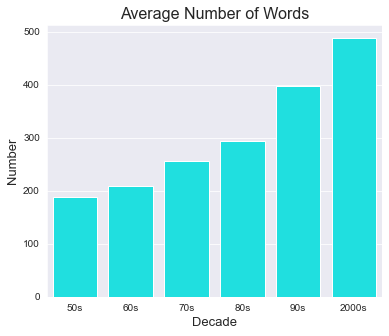

In [36]:
#plotting average number of words by decade
fig, ax = plt.subplots(figsize=(6,5))
bar_plot = sns.barplot(x=decades_mean.index, y='N_words', data=decades_mean, ax=ax, color = 'cyan', order=['50s', '60s', '70s', '80s', '90s', '2000s'])
plt.xlabel("Decade", size=13)
plt.ylabel("Number", size=13)
plt.title('Average Number of Words', fontsize = 16);

Songs between 1950 and 2000 generally had a high positive sentiment score. Songs post-2000 also have a positive score, but lower than before. This could be due to different genres, such as Rap, becoming more popular in recent decades, as will be seen in the analysis further down. 

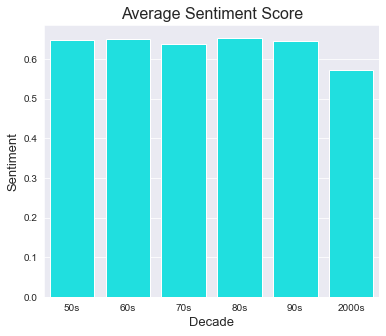

In [37]:
#plotting average sentiment score
fig, ax = plt.subplots(figsize=(6,5))
bar_plot = sns.barplot(x=decades_mean.index, y='SentScore', data=decades_mean, ax=ax, color = 'cyan', order=['50s', '60s', '70s', '80s', '90s', '2000s'])
plt.xlabel("Decade", size=13)
plt.ylabel("Sentiment", size=13)
plt.title('Average Sentiment Score', fontsize = 16);

### IV.IV Overall Word Analysis

#### IV.III.I Word Frequency

Creating a frequency distribution to analyse most frequent words:

In [38]:
fdist = nltk.FreqDist(all_words)

print('TOP 10 FREQUENT WORDS:')
for word in list(fdist)[:10]:
    print(f'{word.capitalize()} appears {fdist[word]} times.')


TOP 10 FREQUENT WORDS:
Be appears 93175 times.
I appears 87659 times.
You appears 83158 times.
The appears 55355 times.
To appears 50275 times.
And appears 36504 times.
Me appears 34845 times.
It appears 34413 times.
A appears 30859 times.
Not appears 30439 times.


The most common words are pronouns, which was expected given that this is a song lyric dataset, particularly words such as 'I', 'you', and 'me'. The verb 'to be' also makes frequent appearances. There are also a number of conjuctions which are common in the English language and do not provide much information, such as 'the' or 'a'.

<b>What if stopwords are excluded? </b>

In this case, the word 'love' is the most common word, which given the dataset was expected. Interestingly, none of the top 10 words appearing in the Top 10 Most Frequent Words above, which included stopwords, appear here - this means that all the most frequent words identified above were stopwords. Considering that almost 54% of all words in the dataset are stopwords, this is not surprising.

Other commonly used words are verbs such as 'get', 'know', and 'go', which explains the high frequency of verbs in the above frequency plot. The noun 'baby' is also quite common, tying in with the love theme of most songs.


In [39]:
fdist_xsw = nltk.FreqDist(all_words_xsw)

print('TOP 10 FREQUENT WORDS (EXCLUDING STOPWORDS):')
for word in list(fdist_xsw)[:10]:
    print(f'{word.capitalize()} appears {fdist_xsw[word]} times.')

TOP 10 FREQUENT WORDS (EXCLUDING STOPWORDS):
Love appears 19638 times.
Get appears 18930 times.
Go appears 16087 times.
Know appears 13482 times.
Baby appears 11912 times.
Want appears 11778 times.
Like appears 10506 times.
Oh appears 10071 times.
Say appears 8726 times.
Make appears 8077 times.


#### IV.III.II Parts of Speech

The below code uses NLTK Part of Speech tagging to analyse the distribution of parts of speech for all words in the dataset. Counts are obtained using the 'Counter' object from the 'collections' module. 

In [40]:
pos = [tag for word, tag in nltk.pos_tag(all_words)]
pos_counts = Counter(pos) #counting instances of each tag

NLTK provides too many parts of speech tags to work with, so we group the tags into larger cohorts. It can be observed that despite the high frequency of certain pronouns, verbs are the most common type of word that appear in the songs. The 'Other' group mainly consists of determiners and conjuctions, which are some of the most commonly used words in the English language and explain this cohort's high frequency.

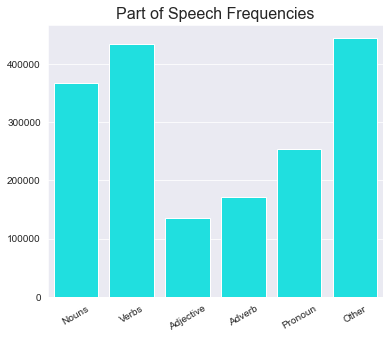

In [41]:
#create dictionary and group word tags into cohorts
pos_groups = {}
pos_groups['Nouns'] = sum([pos_counts[tag] for tag in pos_counts.keys() if tag.startswith('N')])
pos_groups['Verbs'] = sum([pos_counts[tag] for tag in pos_counts.keys() if tag.startswith('V')])
pos_groups['Adjective'] = sum([pos_counts[tag] for tag in pos_counts.keys() if tag.startswith('J')])
pos_groups['Adverb'] = sum([pos_counts[tag] for tag in pos_counts.keys() if tag.startswith('R')]) + pos_counts['WRB']
pos_groups['Pronoun'] = pos_counts['PRP'] + pos_counts['PRP$'] + pos_counts['WP'] + pos_counts['WP$']
pos_groups['Other'] = len(all_words) - sum([pos_groups[tag] for tag in pos_groups.keys() if tag != 'Other'])


#convert dictionary to pandas series and plot pos frequencies
pos_groupings = pd.Series(pos_groups)

fig, ax = plt.subplots(figsize=(6,5))
pos_plot = sns.barplot(x=pos_groupings.index, y=pos_groupings.values, ax=ax, color='cyan')
plt.title('Part of Speech Frequencies', fontsize = 16)
plt.xticks(rotation=30); #semicolon removes annoying text that is outputted before plot

#### IV.III.III WordCloud

Generating wordcloud of most frequent words excluding stopwords. The 'love' theme is again evident.

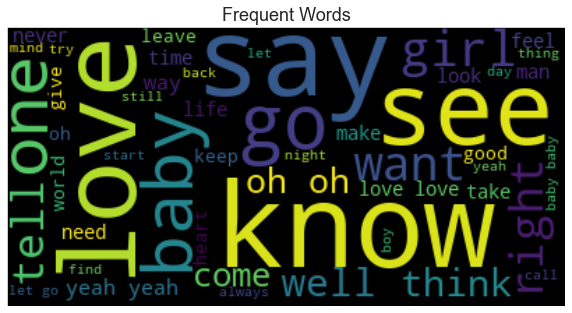

In [42]:
#need to form a string of all words for wordcloud
str_all_words_xsw = ' '.join(word for word in all_words_xsw) 

#generating wordcloud
wc = WordCloud(max_words=50, background_color="black") 
wc.generate(str_all_words_xsw) 

#plotting
fig, ax = plt.subplots(figsize=(10, 10)) 
ax.imshow(wc, interpolation='bilinear') 
ax.set_title("Frequent Words",fontsize=18)
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)

#### IV.III.IV Bigram Analysis

Seeing the most common bigrams (excluding stopwords), it can be observed that a number of words are repeated in succession, which can be common in songs. The below code condenses words that are repeated in succession into one element.

In [43]:
#n-gram of original data
bigram_1 = bigrams(all_words_xsw)
bigram_1_fd = FreqDist(bigram_1).most_common(10)

print('The following are the most common bigrams before condensing successive repetitions:')
for ngram, freq in bigram_1_fd:
    print(ngram)

The following are the most common bigrams before condensing successive repetitions:
('oh', 'oh')
('yeah', 'yeah')
('love', 'love')
('let', 'go')
('get', 'get')
('baby', 'baby')
('go', 'go')
('oh', 'yeah')
('ooh', 'ooh')
('know', 'know')


In [44]:
#condensing successive repetitions
all_words_xsw = [i[0] for i in groupby(all_words_xsw)]

In [45]:
#n-gram of condensed data
bigram_2 = bigrams(all_words_xsw)
bigram_2_fd = FreqDist(bigram_2).most_common(10)
print('\nNow we have the most common bigrams without successive repetitions:')
for ngram, freq in bigram_2_fd:
    print(f'{ngram} appears {freq} times')


Now we have the most common bigrams without successive repetitions:
('let', 'go') appears 1154 times
('oh', 'yeah') appears 742 times
('oh', 'baby') appears 629 times
('love', 'baby') appears 622 times
('go', 'get') appears 621 times
('feel', 'like') appears 592 times
('want', 'know') appears 571 times
('come', 'back') appears 562 times
('know', 'love') appears 558 times
('know', 'get') appears 536 times


Create frequency plot of most common bigrams. Interestingly, 'let go' is the most common bigram, suggesting that many songs with the love theme are about past loves that the singer is trying to forget.

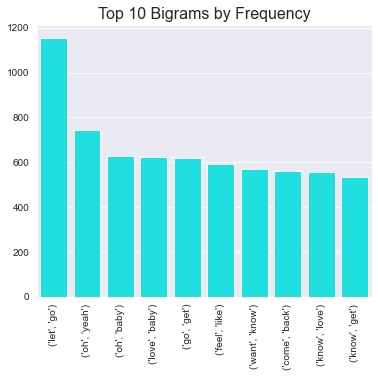

In [46]:
#first convert bigram distribution to dictionary and then to pandas series
bigram_2_dict = {n:(f) for f,n in bigram_2_fd}
bigram_2_fdist = pd.Series(bigram_2_dict)

#plotting
fig, ax = plt.subplots(figsize=(6,5))
bar_plot = sns.barplot(x=bigram_2_fdist.values, y=bigram_2_fdist.index, ax=ax, color = 'cyan')
plt.title('Top 10 Bigrams by Frequency', fontsize = 16)
plt.xticks(rotation=90);


## V. Analysis - by Genre

### V.I Filtering Dataframe

From above, we know that the 'Genre' column contains a number of missing values. I filter out these null values from the dataframe for this part of the analysis.

In [47]:
#create new dataframe for the 'Genre' analysis
df_genres = data_cl.copy()
df_genres = df_genres[df_genres['Genre'].notnull()] #filter out none values
print(f'Filtered dataframe contains {len(df_genres)} observations.')

Filtered dataframe contains 3303 observations.


Analysing number of observations by Genre, we can see that many genres have very few observations. For the purposes of this analysis, we will focus on genres with more than 250 observations, so Hip Hop/Rap, Pop, R&B, and Rock.

In [48]:
#counting number of observations by genre
genres = df_genres['Genre'].unique() #unique genres
genre_counts = {} #dictionary to store counts by genre

#counting and storing
for genre in genres:
    genre_counts[genre] = (df_genres[df_genres['Genre'] == genre].count()[0]) 
    #count returns a count for each column of dataframe, which are all the same. 
    #we index with 0 to get one number (of the first column) 

#sorting dictionary
genre_counts_sorted = {k: v for k, v in sorted(genre_counts.items(), key=lambda item: item[1])}
print(genre_counts_sorted)


{'Classical': 1, 'African': 1, 'Reggae': 3, 'Soundtrack': 4, 'New Age': 5, 'Comedy': 5, 'Latin': 10, 'Vocal': 11, 'Oldies': 12, 'Musical': 12, 'World': 15, 'Ska': 17, 'Adult Contemporary': 18, 'Christian': 19, 'Dance': 21, 'Folk': 22, 'Soul': 38, 'Electronic': 52, 'Jazz': 71, 'Blues': 116, 'Country': 168, 'Hip Hop/Rap': 318, 'Pop': 610, 'R&B': 662, 'Rock': 1092}


Filtering dataframe by chosen genres

In [49]:
df_4genres = df_genres.copy()

genres_analysis = ['Hip Hop/Rap', 'Pop', 'R&B', 'Rock']

df_4genres = df_4genres[df_4genres['Genre'].isin(genres_analysis)]
print(f'Dataframe for genre analysis contains {len(df_4genres)} observations.')
df_4genres.head()

Dataframe for genre analysis contains 2682 observations.


,Title,Year,Decade,Artist,Album,Genre,Lyrics,Lyrics_Clean,Lyrics_Clean_xsw,N_words,N_words_xsw,N_words_dist,SentScore
4,Stereo Hearts,2011,2000s,Gym Class Heroes,The Papercut Chronicles II,Hip Hop/Rap,"My hearts a stereo, it beats for you so listen...","['my', 'heart', 'a', 'stereo', 'it', 'beat', '...","['heart', 'stereo', 'beat', 'listen', 'close',...",458,219,147,0.9872
6,Cheers (Drink To That),2011,2000s,Rihanna,Loud,R&B,"Yeah-e-yeah, yeah-e-yeah, yeah-e-yeah. Yeah-e-...","['yeaheyeah', 'yeaheyeah', 'yeaheyeah', 'yeahe...","['yeaheyeah', 'yeaheyeah', 'yeaheyeah', 'yeahe...",461,255,92,0.9662
11,Lighters,2011,2000s,Bad Meets Evil,HellThe Sequel (EP),Hip Hop/Rap,This one's for you and me. Livin' out our drea...,"['this', 'one', 'be', 'for', 'you', 'and', 'me...","['one', 'livin', 'dream', 'right', 'arm', 'wid...",882,375,315,-0.9664
18,Good Life,2011,2000s,OneRepublic,Waking Up,Rock,Woke up in London yesterday. Found myself in t...,"['wake', 'up', 'in', 'london', 'yesterday', 'f...","['wake', 'london', 'yesterday', 'find', 'city'...",449,226,118,0.9987
25,She Will,2011,2000s,Lil Wayne,Tha Carter IV,Hip Hop/Rap,[feat. Drake]. . Young Money. . [Lil Wayne:]. ...,"['feat', 'drake', 'young', 'money', 'lil', 'wa...","['feat', 'drake', 'young', 'money', 'lil', 'wa...",777,319,195,-0.9382


Extracting lyrics data for each genre and storing in dictionary, and creating list of all words by genre.

In [50]:
#list of tokenised songs by genre
genre_songs = {}
for genre in genres_analysis:
    genre_filter = df_4genres[df_4genres['Genre'] == genre] #filter df by genre
    genre_tokens = [genre_filter.iloc[row,7] for row in range(len(genre_filter))] #get token list from each song in genre
    genre_songs[genre] =  [ast.literal_eval(lst) for lst in genre_tokens] #converting to list from string representation

#we now have a dictionary of songs by genre - convert this into one list of all words per genre 
all_words_by_genre = {}
for genre in genres_analysis:
    temp_list = []
    for song in genre_songs[genre]:
        for word in song:
            temp_list.append(word)
        
    temp_list = [i[0] for i in groupby(temp_list)] #removing successive word repetitions
    all_words_by_genre[genre] = temp_list    

Doing the same to extract list of all words excluding stopwords, for each genre.

In [51]:
#list of tokenised songs by genre
genre_songs_xsw = {}
for genre in genres_analysis:
    genre_filter_xsw = df_4genres[df_4genres['Genre'] == genre]
    genre_tokens_xsw = [genre_filter_xsw.iloc[row,8] for row in range(len(genre_filter_xsw))] 
    genre_songs_xsw[genre] =  [ast.literal_eval(lst) for lst in genre_tokens_xsw] #converting from string representation

#all words by genre
all_words_genre_xsw = {}
for genre in genres_analysis:
    temp_list = []
    for song in genre_songs_xsw[genre]:
        for word in song:
            temp_list.append(word)
        
    temp_list = [i[0] for i in groupby(temp_list)] #removing successive repetitions
    all_words_genre_xsw[genre] = temp_list    

### V.II Overview

Analysing word frequencies by genre, we can see that the Hip Hop/RAP genre contains more distinct words than the other genres, and a lower percentage of stopwords.

In [52]:
for genre in genres_analysis:
    total_words = len(all_words_by_genre[genre])
    total_words_xsw = len(all_words_genre_xsw[genre])
    distinct_words = len(set(all_words_by_genre[genre]))
    pc_stopwords = ((total_words - total_words_xsw)/total_words)*100
    pc_distinct = (distinct_words/total_words)*100
    print(f'The {genre.upper()} dataset totals {total_words} words (of which {round(pc_stopwords,1)}% are stopwords). There are {distinct_words} distinct words ({round(pc_distinct,2)}% of total)')



The HIP HOP/RAP dataset totals 200091 words (of which 53.0% are stopwords). There are 8381 distinct words (4.19% of total)
The POP dataset totals 195574 words (of which 57.4% are stopwords). There are 5122 distinct words (2.62% of total)
The R&B dataset totals 221393 words (of which 57.3% are stopwords). There are 5087 distinct words (2.3% of total)
The ROCK dataset totals 286680 words (of which 56.8% are stopwords). There are 6438 distinct words (2.25% of total)


In [53]:
#grouping by genre averages
genres_mean = df_4genres.groupby('Genre').mean()

Interestingly, the lexicon-based VADER sentiment analyser on average classifies all genres as positive. This could be a result of common phrases such as 'love', 'dream', and 'like', which are classified as positive by the analyser. On the other hand, Hip Hop/Rap, though still positive, has a much lower sentiment score, probably reflecting the large amount of profanities normally present in such songs.

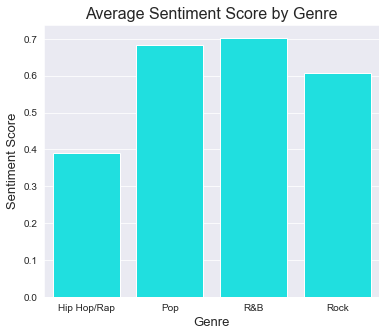

In [54]:
#plotting average sentiment scores by genre
fig, ax = plt.subplots(figsize=(6,5))
bar_plot = sns.barplot(x=genres_mean.index, y='SentScore', data=genres_mean, ax=ax, color = 'cyan')
plt.xlabel("Genre", size=13)
plt.ylabel("Sentiment Score", size=13)
plt.title('Average Sentiment Score by Genre', fontsize = 16);


As already observed, the average length of a Hip Hop/Rap song is much longer than the other genres. On the other hand, R&B, Rock, and Pop songs have similar lengths. 

This could be a feature of the dataset - when a song has a chorus, the lyrics only include the chorus once rather than every time it is said. This might explain why genres which don't make much use of choruses, such as Rap, might have more words in this particular dataset.

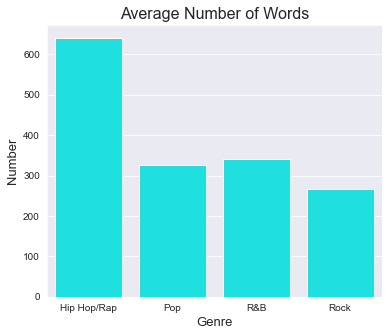

In [55]:
#plotting average number of words by genre
fig, ax = plt.subplots(figsize=(6,5))
bar_plot = sns.barplot(x=genres_mean.index, y='N_words', data=genres_mean, ax=ax, color = 'cyan')
plt.xlabel("Genre", size=13)
plt.ylabel("Number", size=13)
plt.title('Average Number of Words', fontsize = 16);

Similarly, Hip Hop/Rap songs have more distinct words than other genres, almost double. Again, this might be explained by the lack of a chorus in many rap songs, which tend to be more poem-style.

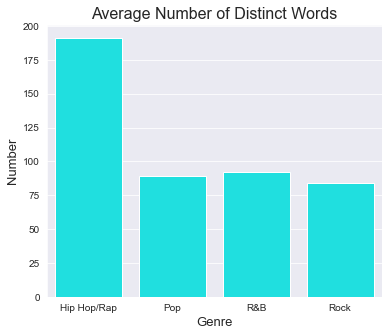

In [56]:
#plotting average number of distinct words by genre
fig, ax = plt.subplots(figsize=(6,5))
bar_plot = sns.barplot(x=genres_mean.index, y='N_words_dist', data=genres_mean, ax=ax, color = 'cyan')
plt.xlabel("Genre", size=13)
plt.ylabel("Number", size=13)
plt.title('Average Number of Distinct Words', fontsize = 16);

### V.III WordClouds and Word Frequency

We can see that the love theme is evident, with words like 'love', 'baby', 'dream', 'girl', and 'heart' making frequent appearances. The word 'love' is the most frequently used word in the R&B, Pop, and Rock genres.

However, interestingly the word 'love' does not appear in the top 10 frequent words for the Hip Hop/Rap genre. This genre also contains more taboo/swear words than other genres, with the worldcloud containing words such as 'fuck', 'shit', 'bitch', and 'nigga'.

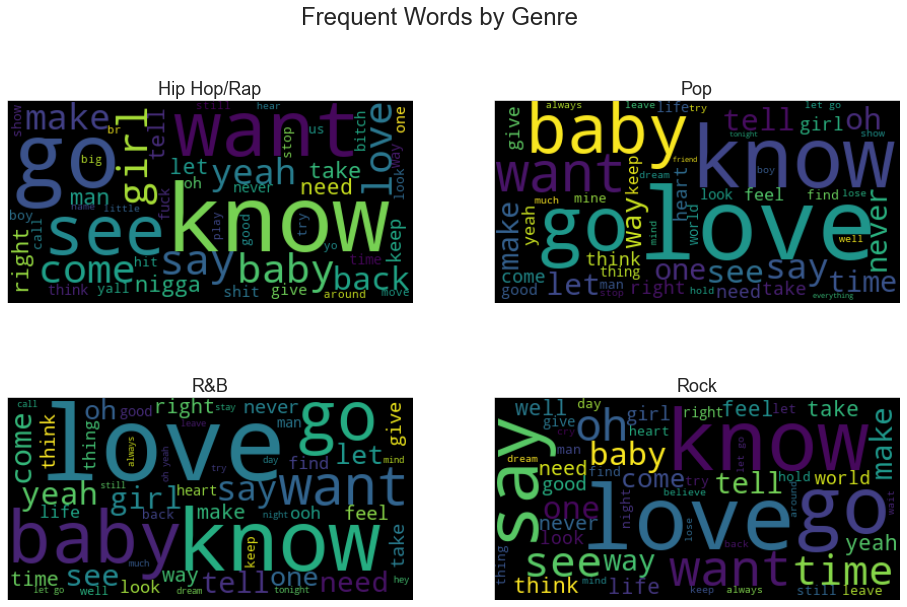

In [57]:
genre_strings = {} #dictionary storing wordcloud strings
for genre in genres_analysis:
    genre_strings[genre] = ' '.join(word for word in all_words_genre_xsw[genre]) #string of all words

#Generating wordclouds
wc_rap = WordCloud(max_words=50, background_color="black")
wc_rap.generate(genre_strings['Hip Hop/Rap']) 

wc_pop = WordCloud(max_words=50, background_color="black")
wc_pop.generate(genre_strings['Pop']) 

wc_rb = WordCloud(max_words=50, background_color="black")
wc_rb.generate(genre_strings['R&B']) 

wc_rock = WordCloud(max_words=50, background_color="black")
wc_rock.generate(genre_strings['Rock']) 
    
# #plotting
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10)) 
fig.suptitle('Frequent Words by Genre\n', fontsize=24)

ax[0,0].imshow(wc_rap, interpolation='bilinear')
ax[0,0].set_title("Hip Hop/Rap",fontsize=18)
ax[0,0].yaxis.set_visible(False)
ax[0,0].xaxis.set_visible(False)

ax[0,1].imshow(wc_pop, interpolation='bilinear')
ax[0,1].set_title("Pop",fontsize=18)
ax[0,1].yaxis.set_visible(False)
ax[0,1].xaxis.set_visible(False)

ax[1,0].imshow(wc_rb, interpolation='bilinear')
ax[1,0].set_title("R&B",fontsize=18)
ax[1,0].yaxis.set_visible(False)
ax[1,0].xaxis.set_visible(False)

ax[1,1].imshow(wc_rock, interpolation='bilinear')
ax[1,1].set_title("Rock",fontsize=18)
ax[1,1].yaxis.set_visible(False)
ax[1,1].xaxis.set_visible(False)

In [58]:
#generating frequency distributions
for genre in genres_analysis:
    fdist_genre = nltk.FreqDist(all_words_genre_xsw[genre])
    print(f'\nTOP 10 FREQUENT WORDS IN {genre.upper()} GENRE:')
    for word in list(fdist_genre)[:10]:
        print(f'{word.capitalize()} appears {fdist_genre[word]} times.')


TOP 10 FREQUENT WORDS IN HIP HOP/RAP GENRE:
Get appears 2942 times.
Like appears 1721 times.
Go appears 1501 times.
Know appears 1419 times.
Want appears 1240 times.
Make appears 955 times.
Baby appears 909 times.
See appears 795 times.
Girl appears 759 times.
Let appears 758 times.

TOP 10 FREQUENT WORDS IN POP GENRE:
Love appears 2412 times.
Go appears 1812 times.
Get appears 1800 times.
Want appears 1546 times.
Know appears 1506 times.
Baby appears 1406 times.
Like appears 1100 times.
Say appears 925 times.
Come appears 904 times.
Make appears 897 times.

TOP 10 FREQUENT WORDS IN R&B GENRE:
Love appears 3070 times.
Get appears 2058 times.
Go appears 1875 times.
Baby appears 1817 times.
Know appears 1766 times.
Want appears 1670 times.
Oh appears 1270 times.
Say appears 1104 times.
Let appears 1094 times.
Like appears 1086 times.

TOP 10 FREQUENT WORDS IN ROCK GENRE:
Love appears 2851 times.
Go appears 2546 times.
Get appears 2435 times.
Know appears 2162 times.
Want appears 1750 ti

### V.IV Bigram Analysis

The bigram 'let go' is very common accross all genres. The most common bigram in the Hip Hop/Rap genre is the slang 'hey yo', with 'yo hey' also appearing multiple times.

Again, for the other three genres, the love theme is very common, with common bigrams such as 'oh baby', 'love baby', and 'come back'. Verbs such as 'want' and 'fall' are also very common.

In [59]:
for genre in genres_analysis:
    bigram_genre = bigrams(all_words_genre_xsw[genre])
    bigram_fd = FreqDist(bigram_genre).most_common(10)
    print(f'\n10 MOST COMMON BIGRAMS ({genre})')
    for ngram, freq in bigram_fd:
        print(f'{ngram} appears {freq} times')



10 MOST COMMON BIGRAMS (Hip Hop/Rap)
('hey', 'yo') appears 110 times
('let', 'go') appears 100 times
('let', 'get') appears 88 times
('go', 'get') appears 88 times
('yo', 'hey') appears 85 times
('get', 'low') appears 84 times
('know', 'get') appears 78 times
('want', 'go') appears 75 times
('feel', 'good') appears 69 times
('yeah', 'br') appears 66 times

10 MOST COMMON BIGRAMS (Pop)
('let', 'go') appears 161 times
('come', 'back') appears 92 times
('want', 'back') appears 87 times
('oh', 'baby') appears 86 times
('really', 'want') appears 85 times
('get', 'love') appears 84 times
('want', 'love') appears 82 times
('love', 'give') appears 77 times
('feel', 'like') appears 76 times
('go', 'get') appears 76 times

10 MOST COMMON BIGRAMS (R&B)
('let', 'go') appears 152 times
('oh', 'yeah') appears 147 times
('oh', 'baby') appears 122 times
('doo', 'dit') appears 120 times
('love', 'baby') appears 118 times
('fall', 'love') appears 104 times
('want', 'get') appears 93 times
('come', 'bac

## VI. Conclusions, Limitations & Ethical Considerations

The aim of this initial analysis was to provide an overview of the common themes behind the lyrics of the world's most popular songs, and also to understand differences between music genres in terms of lyrics. 

The songs studied were generally classed as positive, with 'love' being the most popular theme. This is particularly so with the pop, rock, and R&B genres. Indeed, the analysis showed that there was no surface-level difference between these three genres in terms of lyrics. Lyrics are just one part of music - it could be the case that these genres differ on other musical aspects, such as melody or pitch. On the other hand, Hip Hop and Rap songs showed sometimes significant differences from other genres - they are longer, have a greater pool of distinct words, make greater use of slang and profane words, and are generally less positive in sentiment than other genres. Understanding these differences in more detail provides scope for further exploration of the dataset. Indeed, given such differences, it would be interested to test whether a trained classifier would be able to distinguish between rap songs and other genres.

Before concluding, I would also like to point out some limitations and ethical considerations of this study. The study was conducted using a publicly available dataset of song lyrics from publicly available songs. It was intended as an exploratory investigation of some of the world's more popular songs and their themes, born out of natural curiosity. The study is not intended to pass judgement on any song or genre. All songs analysed are in the public domain.

The website from which the song lyrics were scraped is a social network-style site that allows users to post lyrics or corrections to lyrics. I am not aware of the review process that goes into these lyrics prior to their publication, and hence there is no guarantee that the lyrics used are 100% accurate. Furthermore, although I attempted to manually clean the most common contractions and slang words from the lyrics, I cannot gaurantee that all non-dictionary tokens were removed from the dataset.

Finally, the dataset was scraped from lists of the Top 100 Songs per year. This could give rise to biases in the results, because ultimately there may be themes or styles that are generally more popular than others. Indeed, the overwhelming dominance of the 'love' theme over other themes could in part be a result of user bias - songs about love are generally more likely to be upvoted than songs about loss or war, and hence more likely to appear in a dataset of popular songs. An interesting extension to this study would be exanding the dataset with songs that are not necessarily the most popular, and examining whether a more diverse array of themes emerges.

Any errors and conclusions presented in this study are the author's own.



## VII. Resources Used

<b>WEBSITES</b>
<ul>
    <li>Sharpe, C. (2018). 49 Years of Lyrics: A Python based study of the change in language for popular music from 1970 to 2018. Available: https://towardsdatascience.com/49-years-of-lyrics-why-so-angry-1adf0a3fa2b4</li>
    <li>Panda, P. (2018). The Data Science of “Someone Like You”. Available: https://www.kdnuggets.com/2018/09/sentiment-analysis-adele-songs.html  </li>
    <li>StackOverflow (2013). Expanding English language contractions in Python. Available: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python</li>
    <li>GeeksforGeeks (2020). NLP – Expand contractions in Text Processing. Available: https://www.geeksforgeeks.org/nlp-expand-contractions-in-text-processing/ </li>
    <li>RustyonRampage (2017). Correcting Words using Python and NLTK. Available:
https://rustyonrampage.github.io/text-mining/2017/11/28/spelling-correction-with-python-and-nltk.html </li>
    <li>DelftStack (2021). Remove Non-Alphanumeric Characters From Python String. Available: https://www.delftstack.com/howto/python/remove-non-alphanumeric-characters-python/</li>
    <li>GeeksforGeeks (2020). NLP – Expand contractions in Text Processing. Available: https://www.geeksforgeeks.org/nlp-expand-contractions-in-text-processing/ </li>
</ul>

<b>OTHER</b>
<ul>
    <li>Bird et. al (2009). Natural Language Processing with Python. O'Reilly Media, Inc., first edition. </li>
    <li>Jurafsky & Martin (2020). Speech and Language Processing. Third edition draft. </li>
    <li>McGrath, S. University of London. Data Programming in Python Module.</li>
    <li>McKinney, W. Python for Data Analysis (2017). O'Reilly Media, Inc., second edition. </li>
</ul>